# Figures for assignment:
1. Number of patients with asthma diagnosis per year
2. Number of hospital emergency admissions for asthma attacks by quarter

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime

### Number of emergency inpatient admissions for asthma

In [26]:
df = pd.read_csv('output_data/encounters_dump.csv')
df['startTime'] = df.startTime.astype('datetime64')
df = df[df.encounterType_text.str.contains('Emergency.*asthma')]
a = df.groupby('startTime').patientId.count()
a = a[a.index > datetime.datetime.fromisoformat('2015-01-01')]
data = a.resample('Q').count().sort_index()

Text(0.5, 1.0, 'Number of Emergency Admissions for Asthma\nby Quarter')

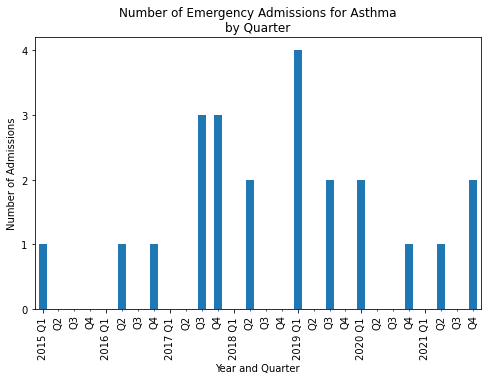

In [32]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
ax = data.plot.bar(ax)
ax.get_xticklabels()
xtick_maj = ax.set_xticks([x*4 for x in range(0,7)])
xtick_min = ax.set_xticks([x for x in range(0,28)], minor=True)
_ = ax.set_xticklabels([f'{y} Q1' for y in range(2015,2022)], minor=False)
_ = ax.set_xticklabels([f'Q{x}' for x in range(1,5)]*7, minor=True, rotation=90)
ax.set_yticks([0,1,2,3,4])
ax.set_ylabel('Number of Admissions')
ax.set_xlabel('Year and Quarter')
ax.set_title('Number of Emergency Admissions for Asthma\nby Quarter')

### Common comorbidities in asthma patients:

In [62]:
full_c = pd.read_csv('./output_data/conditions_dump.csv')
c = full_c[full_c.code_text.str.contains('[Aa]sthma')]
resolved_asthma_patients = c[~c.abatementDateTime.isna()].patientId.unique()
asthma_patients = c.patientId.unique()

In [83]:
tmp = full_c[full_c.patientId.isin(asthma_patients)].loc[:,['patientId', 'code_text']].drop_duplicates()
comorbidities = tmp[tmp.code_text.str.contains('disorder')].code_text.value_counts()
display(comorbidities)
asthma_patients.size

Acute viral pharyngitis (disorder)      15
Viral sinusitis (disorder)              11
Acute bronchitis (disorder)              9
Acute bacterial sinusitis (disorder)     3
Chronic sinusitis (disorder)             2
Streptococcal sore throat (disorder)     1
Anemia (disorder)                        1
Sinusitis (disorder)                     1
Name: code_text, dtype: int64

19

In [99]:
c = pd.read_csv('./output_data/conditions_dump.csv')
c = c.loc[:,['patientId','code_text']].drop_duplicates()
c[~c.code_text.str.contains('finding|Viral|Acute|trimester|pregnancy|Sprain')].code_text.value_counts()


Prediabetes                                                                         155
Anemia (disorder)                                                                   145
Hypertension                                                                        141
Chronic sinusitis (disorder)                                                         87
Otitis media                                                                         78
Streptococcal sore throat (disorder)                                                 73
Hyperlipidemia                                                                       50
Suspected COVID-19                                                                   45
COVID-19                                                                             43
Diabetes                                                                             32
Hypertriglyceridemia (disorder)                                                      31
Osteoporosis (disorder)         

In [84]:
df = pd.read_csv('output_data/encounters_dump.csv')
df.startTime = df.startTime.astype('datetime64[ns]')
df.endTime = df.endTime.astype('datetime64[ns]')


df = df[df.encounterType_text.str.contains('[Aa]sthma')].reset_index().loc[:,['id','patientId','practitioner_name','encounterType_text','startTime','endTime']].sort_values('startTime')
df = df[~df.startTime.isna()]
df = df[df.startTime > datetime.datetime.fromisoformat('2010-01-01 00:00:00')]

df.groupby('practitioner_name').patientId.nunique().sort_values(ascending=False)
df.groupby('practitioner_name').patientId.count().sort_values(ascending=False)
df.sort_values(['practitioner_name','patientId','startTime'])
df[df.encounterType_text.str.contains('Emergency')].groupby('practitioner_name').patientId.count().sort_values(ascending=False)

practitioner_name
Dr. Vicente970 Kilback373       4
Dr. Ginger664 Goodwin327        4
Dr. Regena252 Kunde533          3
Dr. Melvina326 Glover433        3
Dr. Alta896 Schiller186         3
Dr. Margery365 Paucek755        3
Dr. Terrell212 Fadel536         2
Dr. Darrick836 Franecki195      2
Dr. Hal307 Renner328            2
Dr. Louetta798 Thompson596      2
Dr. Ludivina884 Steuber698      1
Dr. Nicolás801 Jiménez568       1
Dr. Aline709 Turner526          1
Dr. Isreal8 Kihn564             1
Dr. Franklin857 Bayer639        1
Dr. Esperanza675 Escobedo608    1
Dr. Ellan282 Jacobi462          1
Dr. Antwan357 Harris789         1
Dr. Ingrid581 Jacobson885       1
Name: patientId, dtype: int64

# Notebook for interactive development and testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import json
import os
from dataclasses import dataclass
import datetime

from resources import *

HOME_DIR = os.path.join(os.getenv('HOMEDRIVE'), os.getenv('HOMEPATH'))
data_dir = os.path.join(HOME_DIR, 'Downloads', 'synthea_sample_data_fhir_dstu2_nov2021','fhir_dstu2')
csv_dir =  os.path.join(HOME_DIR, 'Downloads', 'synthea_sample_data_csv_nov2021','csv')
files = os.listdir(data_dir)

In [24]:
with open(os.path.join(data_dir, files[10]), 'r') as f:
    data = json.load(f)

encounters = (x for x in data['entry'] if x['resource']['resourceType']=='Encounter')
medications = (x for x in data['entry'] if x['resource']['resourceType']=='MedicationOrder')
patients = (x for x in data['entry'] if x['resource']['resourceType']=='Patient')
conditions = (x for x in data['entry'] if x['resource']['resourceType']=='Condition')

In [9]:
df_asthma = df[df.DESCRIPTION.str.contains("asthma")]
n_pat = df_asthma.PATIENT.value_counts().to_dict()
vals =  df_asthma.PATIENT.map(n_pat)
df_asthma = df_asthma.reset_index().drop('index', axis=1)
df_asthma['n_adm'] = vals.values

df_asthma.sort_values(['n_adm','START'], ascending=[0,1]).loc[:,['START','n_adm','PATIENT']]

# df_asthma[['PATIENT','START']].value_counts()

,START,n_adm,PATIENT
12,2013-02-15T03:04:14Z,4,426cade9-82be-f335-7340-c4413e4bdd6a
13,2017-07-27T01:04:14Z,4,426cade9-82be-f335-7340-c4413e4bdd6a
14,2019-01-20T17:04:14Z,4,426cade9-82be-f335-7340-c4413e4bdd6a
15,2019-07-21T13:04:14Z,4,426cade9-82be-f335-7340-c4413e4bdd6a
16,1941-12-30T10:04:43Z,3,ae59c2c9-648d-6f76-2d42-a1b8cac21c8b
17,1942-06-30T21:04:43Z,3,ae59c2c9-648d-6f76-2d42-a1b8cac21c8b
18,1944-06-21T10:04:43Z,3,ae59c2c9-648d-6f76-2d42-a1b8cac21c8b
5,2012-06-15T22:03:20Z,3,50aac3ff-d836-adfd-620d-662fa08fdf55
36,2012-10-10T10:57:14Z,3,eebbb6c9-87b3-9978-5eab-84edacbccc7c
29,2013-09-25T19:02:17Z,3,863410e4-cd33-2f03-47b6-01fa2bc39753


In [10]:
df1 = df[['PATIENT','DESCRIPTION']].drop_duplicates()
df1[df1.DESCRIPTION.str.contains('disorder')].DESCRIPTION.value_counts()

Allergic disorder initial assessment      53
Allergic disorder follow-up assessment    31
posttraumatic stress disorder              5
Name: DESCRIPTION, dtype: int64